# Titanic - Kaggle

Celem zadania jest stworzenie modelu ML, który będzie w stanie przewidzieć, czy dany pasażer przetrwał katastrofę Titanica na podstawie między innymi jego wieku, płci czy ceny jego biletu

Dane treningowe zostały pobrane z:
https://www.kaggle.com/competitions/titanic

# Analiza danych

Wczytanie danych

In [1]:
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt
import os

def load_titanic_data(filename):
    csv_path = os.path.join("data", filename)
    return ps.read_csv(csv_path)
train_data = load_titanic_data("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing Values

Nasz zbiór danych zawiera null values w trzech kolumnach
1. Age - będziemy estymować wiek z innych wartości
2. Cabin - tutaj aż __70%__ wartości jest nullowych. Zajmiemy się tym później, ale również postaramy się z tego wydobyć jakąś informacje
3. Embarked - dwie wartości nullowe w całym zbiorze. Będziemy to pole nadpisywać wartością najczęściej występującą.

In [2]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Analiza kolumn

### PassengerId

Wartość służąca jedynie indeksowaniu danych. Usuniemy ją ze zbiory w preprocesingu.

### Survived

Wartość docelowa posiadająca dwa labele:
1. Survived = 1
2. Died = 0

Prawdopodobieństwo między labelami jest w miarę równe, więc będziemy mogli użyć accuaracy do oceny modelu

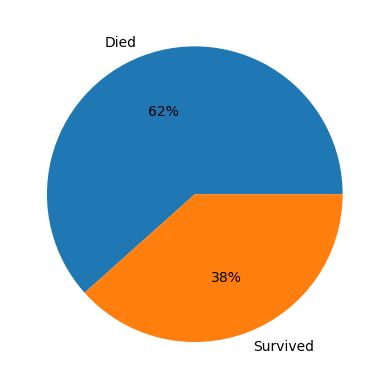

In [3]:
counts = train_data.groupby(['Survived'])['PassengerId'].count()
plt.pie(counts, labels = ["Died", "Survived"], autopct='%.0f%%')
plt.show() 

### Name

Kolumna informuje nas o imieniu pasażera. Możemy z tej kolumny wydobyć informację o tytule, jakim posługiwał się pasażer (mr, mrs, miss itd.). Pomoże nam to między innymi do szacowania wieku przy wypełnianiu Null Values oraz samo pole tytuł będziemy traktować, jako kategoryczne.

### Ticket

Kolumna zawierająca numer biletu. Nie będziemy brali tej kolumny pod uwagę

### Sex  ( ͡° ͜ʖ ͡°)          

Przekonwertujemy tę kolumnę na wartości liczbowe. Z danych bezpośrednio wynika, że mężczyzn przeżyło procentowo zdecydowanie mniej niż kobiet

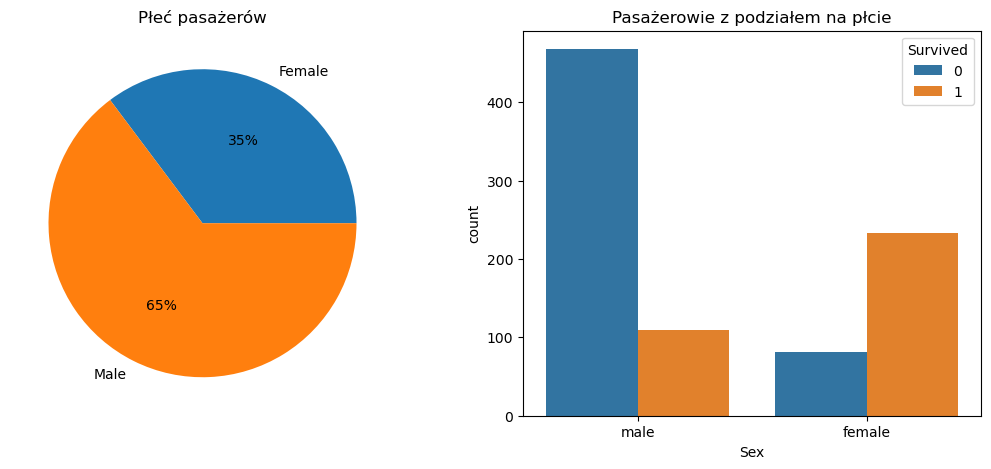

In [4]:
import seaborn as sns
counts = train_data.groupby(['Sex'])['PassengerId'].count()
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].pie(counts, labels = ["Female", "Male"], autopct='%.0f%%')
sns.countplot(ax = ax[1], x='Sex', hue='Survived', data=train_data)
ax[0].title.set_text("Płeć pasażerów")
ax[1].title.set_text("Pasażerowie z podziałem na płcie")
plt.show() 

### Pclass

Wartość numeryczna informująca, w jakiej klasie był pasażer. Istnieje duża korelacja między klasą a szansą przeżycia pasażera.
Pole to będzie traktowane jako numerycznie, ponieważ szansa przeżycia pasażera jest proporcjonalna do wysokości klasy.

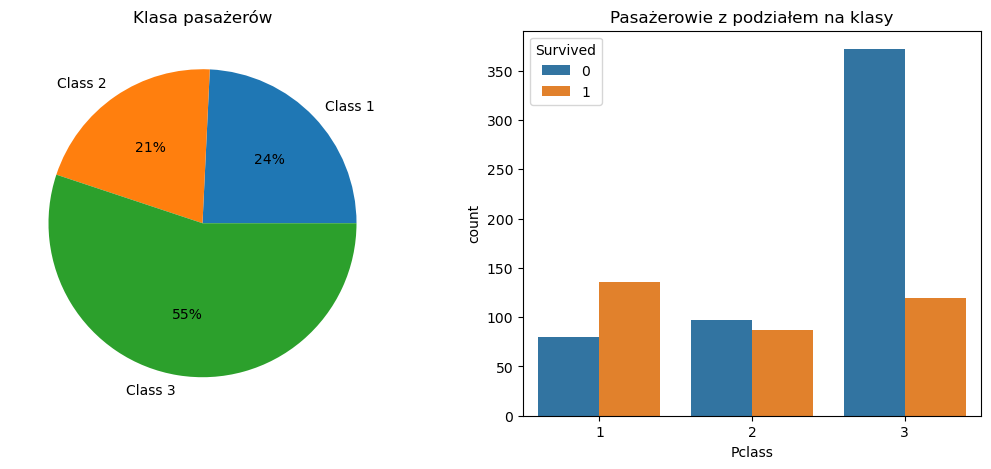

In [5]:
import seaborn as sns
counts = train_data.groupby(['Pclass'])['PassengerId'].count()
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].pie(counts, labels = ["Class 1", "Class 2", "Class 3"], autopct='%.0f%%')
sns.countplot(ax = ax[1], x='Pclass', hue='Survived', data=train_data)
ax[0].title.set_text("Klasa pasażerów")
ax[1].title.set_text("Pasażerowie z podziałem na klasy")
plt.show() 

### Embarked

Zmienna informująca o miejscu zaokrętowania pasażera. Tutaj też istnieją korelacja ze wskaźnikiem przeżycia, ale nie jest tak hierarchiczna, jak w przypadku Pclass. Dlatego tą zmienną będziemy traktować, jako kategoryczną.

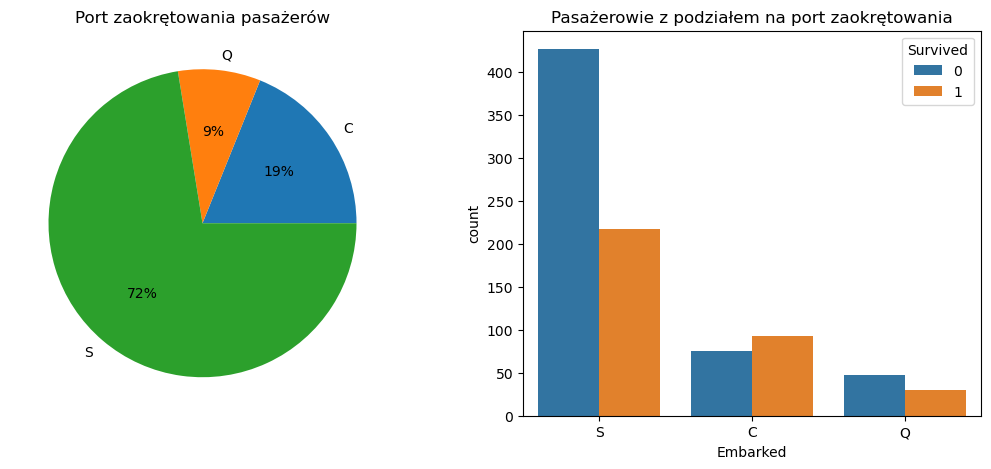

In [6]:
counts = train_data.groupby(['Embarked'])['PassengerId'].count()
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].pie(counts, labels = ["C", "Q", "S"], autopct='%.0f%%')
sns.countplot(ax = ax[1], x='Embarked', hue='Survived', data=train_data)
ax[0].title.set_text("Port zaokrętowania pasażerów")
ax[1].title.set_text("Pasażerowie z podziałem na port zaokrętowania")
plt.show() 

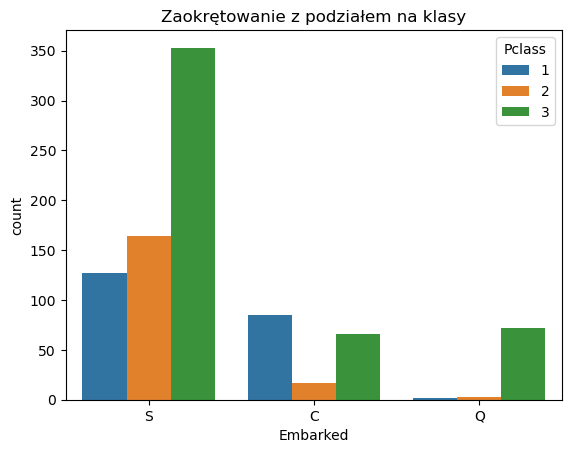

In [7]:
sns.countplot(x='Embarked', hue='Pclass', data=train_data)
plt.title("Zaokrętowanie z podziałem na klasy")
plt.show() 

### Age

Z poniższych wykresów wynika, że największą śmiertelność podczas katastrofy była w grupie ludzi w średnim wieku. Ludzie koło 80 i dzieci w większości przeżyły.

Użyjemy tej kolumny, jako numerycznej

Text(0.5, 1.0, 'Histogram pasażerów w zależności od wieku')

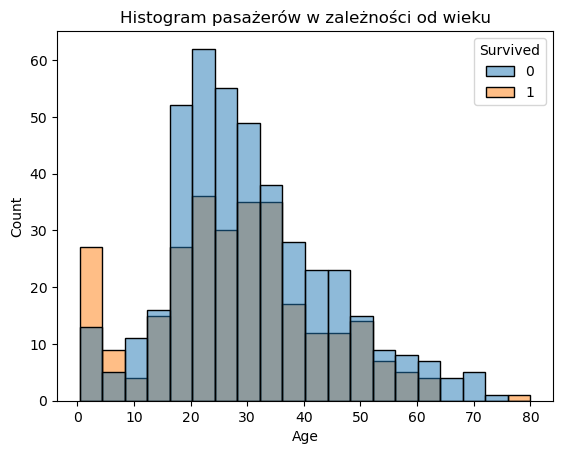

In [8]:
sns.histplot(data=train_data, hue="Survived", x="Age")
plt.title("Histogram pasażerów w zależności od wieku")

Aby ułatwić generalizacje danych, spróbujemy przekonwertować tę kolumnę jako grupy wiekowe też zapisane jako wartość numeryczna. Możliwe, że dzięki temu nasze modele lepiej będą uogólniać dane.

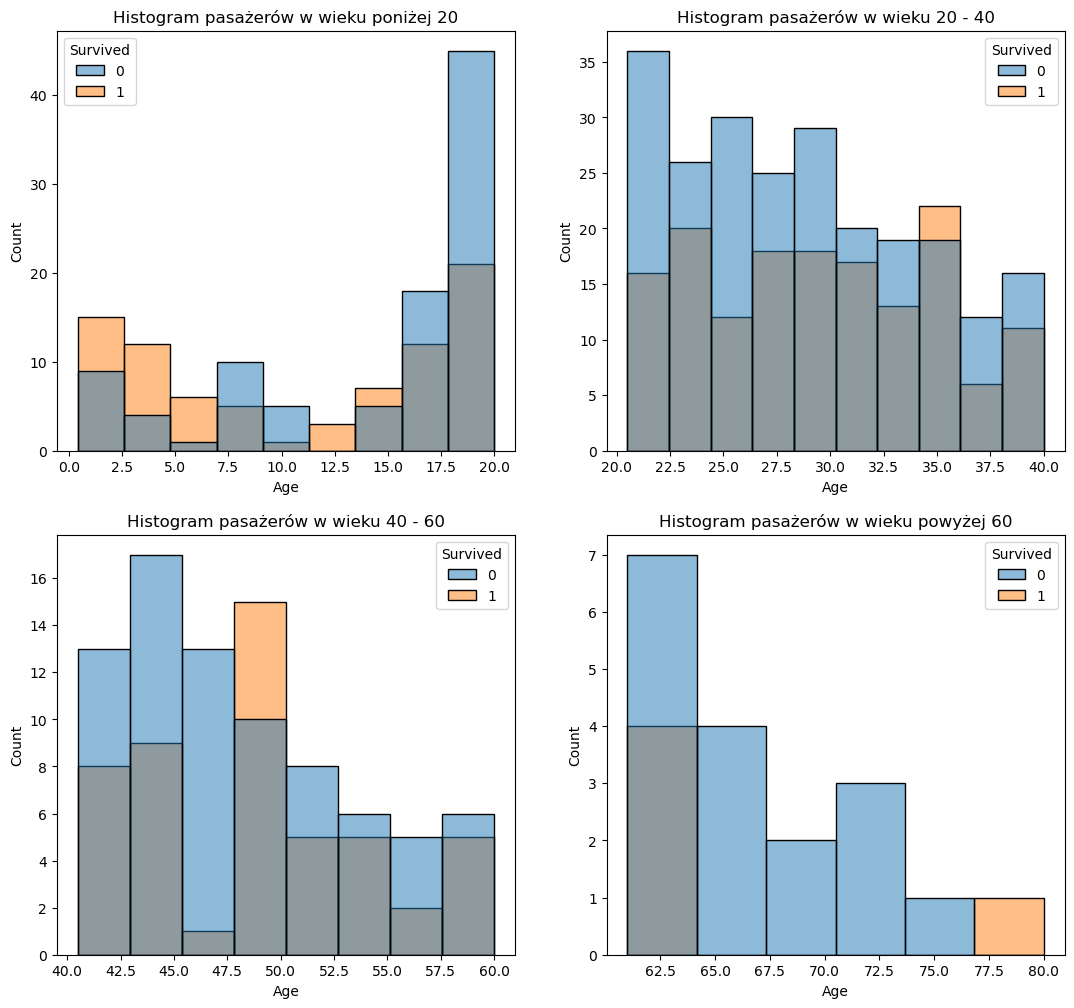

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(13, 12))
sns.histplot(ax = ax[0][0], data=train_data[(train_data['Age'] > 0) & (train_data['Age'] <= 20)], hue="Survived", x="Age")
sns.histplot(ax = ax[0][1], data=train_data[(train_data['Age'] > 20) & (train_data['Age'] <= 40)], hue="Survived", x="Age")
sns.histplot(ax = ax[1][0], data=train_data[(train_data['Age'] > 40) & (train_data['Age'] <= 60)], hue="Survived", x="Age")
sns.histplot(ax = ax[1][1], data=train_data[(train_data['Age'] > 60)], hue="Survived", x="Age")
ax[0][0].title.set_text("Histogram pasażerów w wieku poniżej 20")
ax[0][1].title.set_text("Histogram pasażerów w wieku 20 - 40")
ax[1][0].title.set_text("Histogram pasażerów w wieku 40 - 60")
ax[1][1].title.set_text("Histogram pasażerów w wieku powyżej 60")
plt.show() 

### Fare

Kolumna zawiera informację o cenie biletu pasażera. Cena biletu jest wprost skorelowana z szansą na przeżycie. Tak samo, jak w przypadku kolumny _Age_ podzielimy tę kolumnę na grupy, aby wymusić generalizację danych.

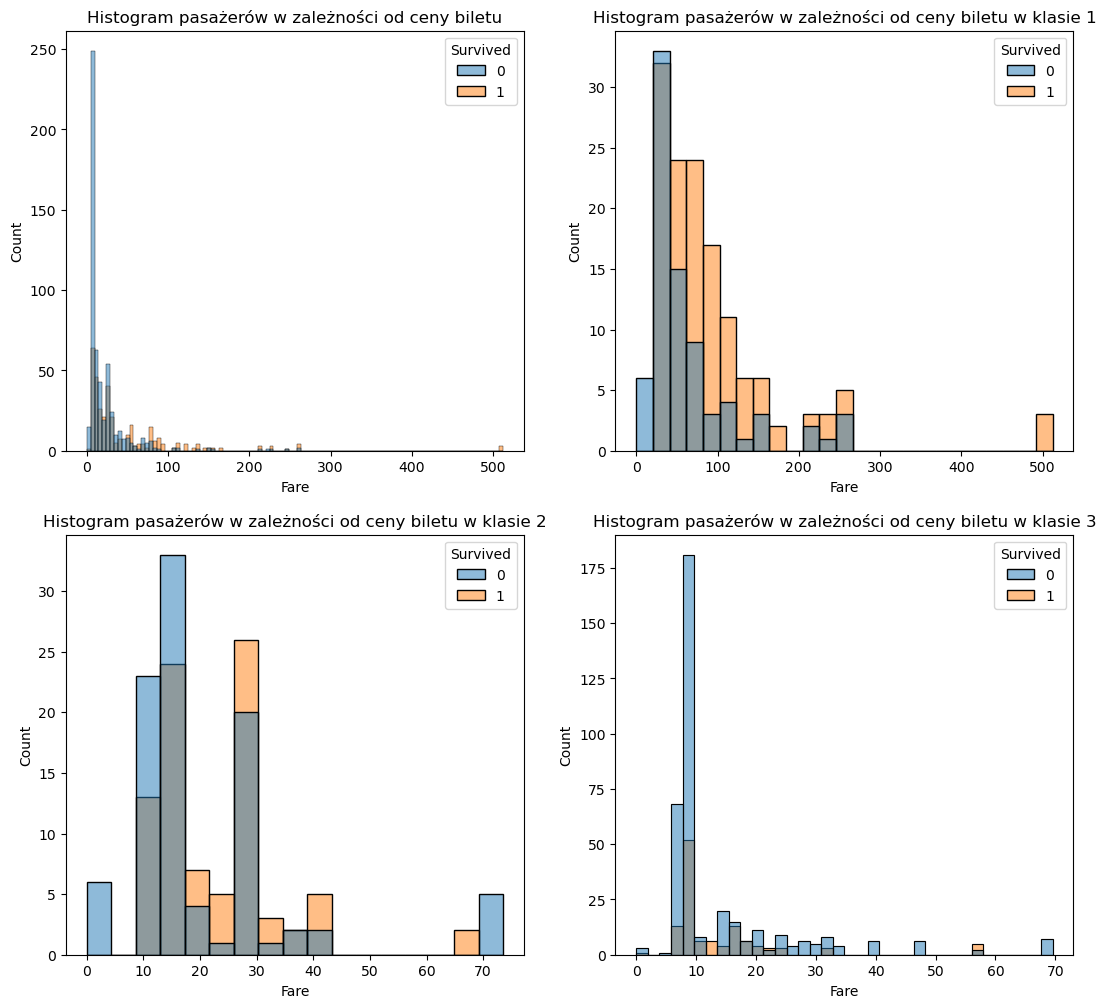

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(13, 12))
sns.histplot(ax = ax[0][0], data=train_data, hue="Survived", x="Fare")
sns.histplot(ax = ax[0][1], data=train_data[train_data['Pclass'] == 1], hue="Survived", x="Fare")
sns.histplot(ax = ax[1][0], data=train_data[train_data['Pclass'] == 2], hue="Survived", x="Fare")
sns.histplot(ax = ax[1][1], data=train_data[train_data['Pclass'] == 3], hue="Survived", x="Fare")
ax[0][0].title.set_text("Histogram pasażerów w zależności od ceny biletu")
ax[0][1].title.set_text("Histogram pasażerów w zależności od ceny biletu w klasie 1")
ax[1][0].title.set_text("Histogram pasażerów w zależności od ceny biletu w klasie 2")
ax[1][1].title.set_text("Histogram pasażerów w zależności od ceny biletu w klasie 3")
plt.show() 

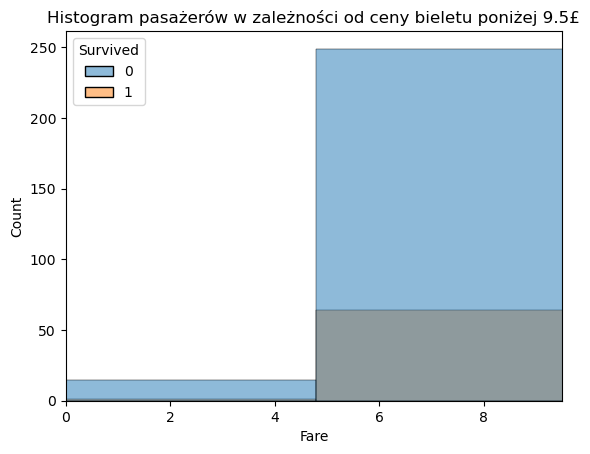

In [11]:
sns.histplot( data=train_data, hue="Survived", x="Fare")
plt.xlim(0, 9.5)
plt.title("Histogram pasażerów w zależności od ceny bieletu poniżej 9.5£")
plt.show() 

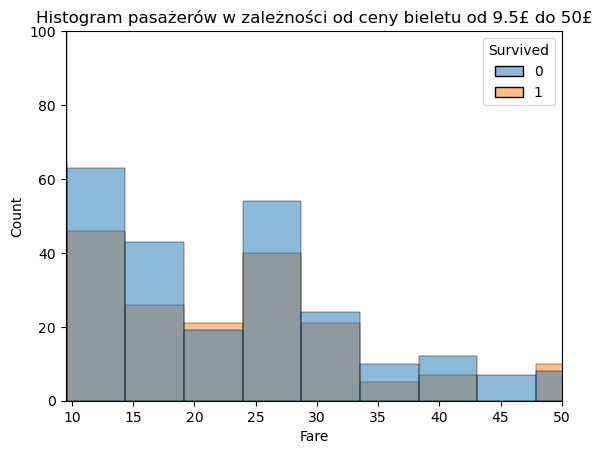

In [12]:
sns.histplot( data=train_data, hue="Survived", x="Fare")
plt.xlim(9.5, 50)
plt.ylim(0, 100)
plt.title("Histogram pasażerów w zależności od ceny bieletu od 9.5£ do 50£")
plt.show()

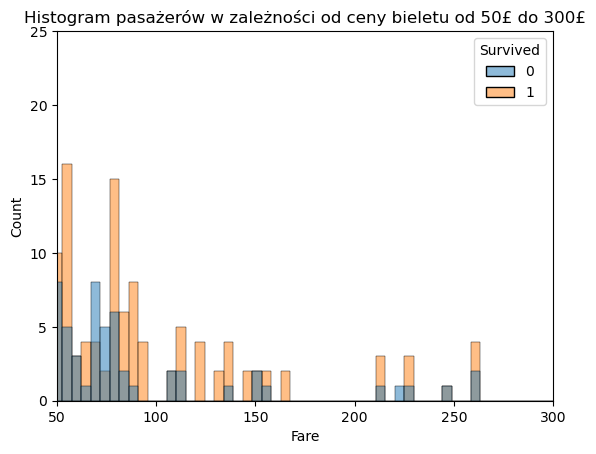

In [13]:
sns.histplot( data=train_data, hue="Survived", x="Fare")
plt.xlim(50, 300)
plt.ylim(0, 25)
plt.title("Histogram pasażerów w zależności od ceny bieletu od 50£ do 300£")
plt.show()

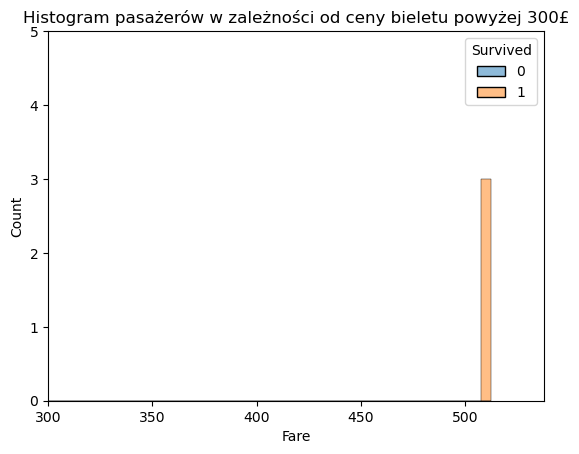

In [14]:
sns.histplot( data=train_data, hue="Survived", x="Fare")
plt.xlim(left = 300)
plt.ylim(0, 5)
plt.title("Histogram pasażerów w zależności od ceny bieletu powyżej 300£")
plt.show()

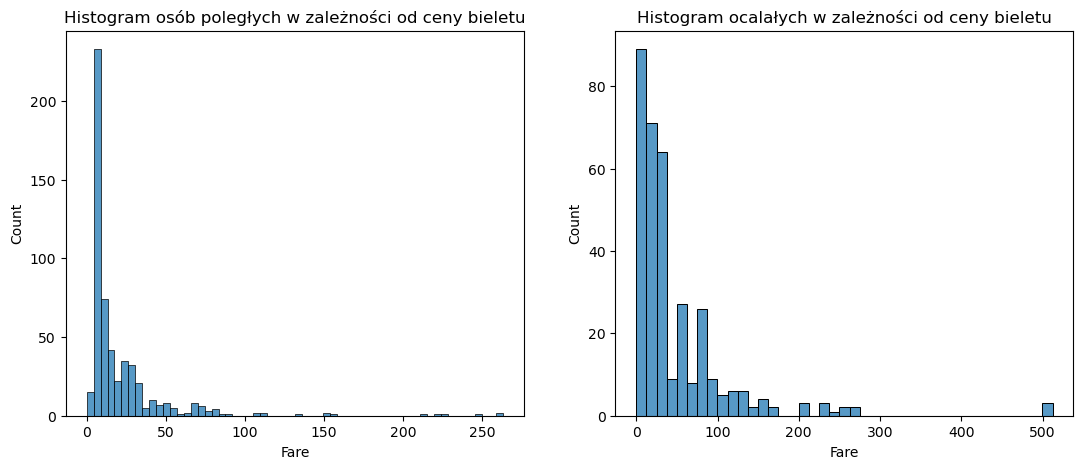

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.histplot(ax = ax[0], data=train_data[train_data['Survived'] == 0], x="Fare")
sns.histplot(ax = ax[1], data=train_data[train_data['Survived'] == 1], x="Fare")
ax[0].title.set_text("Histogram osób poległych w zależności od ceny bieletu")
ax[1].title.set_text("Histogram ocalałych w zależności od ceny bieletu")
plt.show() 

### Cabin

Kolumna cabin zawiera informacje o kabinie przypisanej do pasażera. Możemy z niej wydobyć nr pokładu, gdzie znajduje się kabina pasażera.
W większości jednak kolumna jest wypełniona Null values. Jest to informacja, której później użyjemy w preprocesingu.

### SibSp, Parch

Kolumna SibSp zawiera informacje o ilości rodzeństwa pasażera na statku

Kolumna Parch zawiera informacje o ilości dzieci pasażera na statku

Aby uogólnić dane, dodamy do siebie SibSp i Parch tworząc nową własność

In [16]:
process_data = train_data
process_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Pipeliny

### Usunięcie zbędnych kolumn

Zacznijmy od stworzenia klasy usuwającej kolumny w pipelinie

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class DelColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.columns, axis=1)
del_columns = DelColumns(['Ticket', 'PassengerId'])
process_data = del_columns.transform(process_data)
process_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C148,C


### Title

Stwórzmy klasę, która wyłuska z kolumny _Name_ informacje o tytule i zapisze ją w nowej kolumnie Title.

In [18]:
import re

class TitleCapture(BaseEstimator, TransformerMixin):
    def get_title(idx, name):
        comma_del = re.split(",", name)[1]
        return re.split("\s", comma_del)[1]
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Title'] = X['Name'].map(self.get_title)
        return X

title_capture = TitleCapture()
title_capture.transform(process_data)
process_data['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the',
       'Jonkheer.'], dtype=object)

Z wykresu poniżej widzimy pewne zależności dla każdego tytułu:
1. Największą śmiertelność mają mężczyźni z tytułem _Mr_ (większość załogi statku była zapisana pod tym tytułem)
2. Mężczyźni z tytułem _Master_ mają przeżywalność o wiele wyższą od reszty (tytuł master nadawało się chłopcom poniżej 18 roku życia)
3. Mężatki (_Mrs_) miały większą przeżywalność od panien (_Miss_)

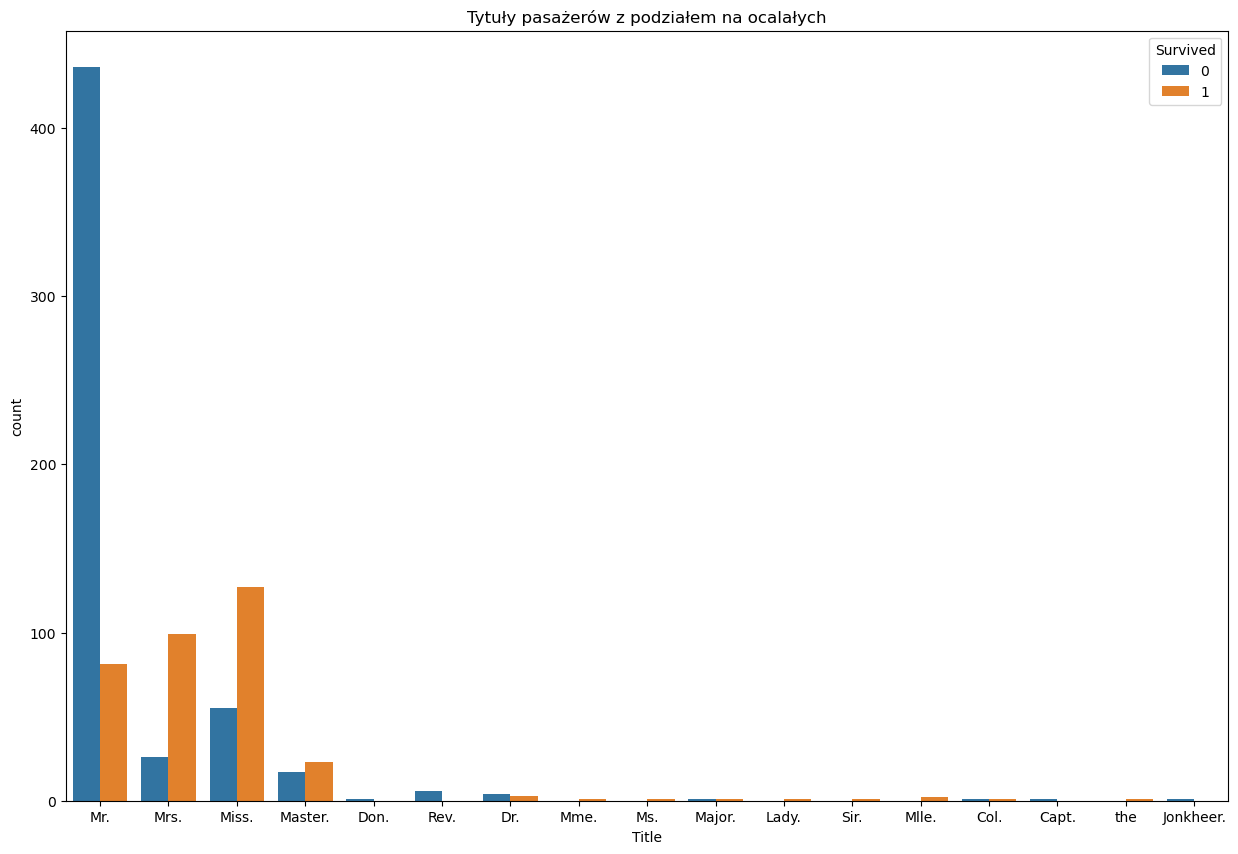

In [19]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Title', hue='Survived', data=process_data)
plt.title("Tytuły pasażerów z podziałem na ocalałych")
plt.show()

In [20]:
titles_count = ps.pivot_table(process_data, values=['Survived', "Age"], index='Title', aggfunc={'Survived': ['mean', 'count'], 'Age': ["min", "max", "mean"]})
titles_count.sort_values(by=[('Survived', 'count')], ascending=False)

Age                   Survived          
            max       mean    min    count      mean
Title                                               
Mr.        80.0  32.368090  11.00      517  0.156673
Miss.      63.0  21.773973   0.75      182  0.697802
Mrs.       63.0  35.898148  14.00      125  0.792000
Master.    12.0   4.574167   0.42       40  0.575000
Dr.        54.0  42.000000  23.00        7  0.428571
Rev.       57.0  43.166667  27.00        6  0.000000
Major.     52.0  48.500000  45.00        2  0.500000
Col.       60.0  58.000000  56.00        2  0.500000
Mlle.      24.0  24.000000  24.00        2  1.000000
Sir.       49.0  49.000000  49.00        1  1.000000
Ms.        28.0  28.000000  28.00        1  1.000000
Capt.      70.0  70.000000  70.00        1  0.000000
Mme.       24.0  24.000000  24.00        1  1.000000
Lady.      48.0  48.000000  48.00        1  1.000000
Jonkheer.  38.0  38.000000  38.00        1  0.000000
Don.       40.0  40.000000  40.00        1  0.000000
the        33.0  33.000000  33.00        1  1.000000

Niektóre tytuły występują tak rzadko, że zrobimy dla nich jeden wspólny label _Rare_. Niektóre za to przekonwertujemy na już istniejące labele

### Rozpiska tytułów

1. Mr. - __dorosły mężczyzna__ Zostawiamy wartość w zbiorze danych
2. Miss. - __kobieta niezamężna__. Zostawiamy wartość w zbiorze danych.
3. Mrs. - __kobiet zamężna__. Zostawiamy wartość w zbiorze danych.
4. Master. - __chłopiec poniżej 12 roku życia__. Zostawiamy wartość w zbiorze danych.
5. Dr. - __doktor__. Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_
6. Rev. - __kleryk__. Grupa rzadko występująca, ale cechująca się zerową przeżywalnością. Zostawiamy wartość w zbiorze danych.
7. Major. - __stopień wojskowy__. Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_
8. Col. - __stopień wojskowy__. Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_
9. Mlle. - __mademoiselle - kobieta niezamężna__. Wrzucamy wartość do zbioru Miss
10. Sir. - __mężczyzna wysoko urodzony__. Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_
11. Ms. - __kobieta niezamężna__. Wrzucamy wartość do zbioru Miss
12. Capt. - __kapitan__ Usuniemy kapitana bo to wartość odstająca
13. Mme - __Madame - kobieta zamężna__ -  Wrzucamy wartość do zbioru Mrs
14. Lady. - __kobieta zamężna__ -  Wrzucamy wartość do zbioru Mrs
15. Jonkheer. - __mężczyzna wysoko urodzony__- Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_
16. Don. - __mężczyzna wysoko urodzony__- Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_
17. the - __cześć jakiegoś dłuższego tytułu - mężczyzna wysoko urodzony__- Wartość bardzo rzadko występująca. Wrzucamy wartość do zbioru _Rare_

In [21]:
class TitleConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Title'] = X['Title'].replace('Mlle.', 'Miss.')
        X['Title'] = X['Title'].replace('Ms.', 'Miss.')
        X['Title'] = X['Title'].replace('Mme.', 'Mrs.')
        X['Title'] = X['Title'].replace('Lady.', 'Mrs.')
        X.loc[~X['Title'].isin(["Mr.", "Miss.", "Mrs.", "Master.", "Rev.", "Mlle", "Ms.", "Mme.", "Lady."]), "Title"] = "Rare"
        return X

title_converter = TitleConverter()
process_data = title_converter.transform(process_data)
del_columns = DelColumns(['Name'])
process_data = del_columns.transform(process_data)
process_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C85,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss.
3,1,1,female,35.0,1,0,53.1000,C123,S,Mrs.
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr.
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S,Rev.
887,1,1,female,19.0,0,0,30.0000,B42,S,Miss.
888,0,3,female,NaN,1,2,23.4500,NaN,S,Miss.
889,1,1,male,26.0,0,0,30.0000,C148,C,Mr.


Każda z utworzonych przez nas grup tytułów ma charakterystyczny rozkład survive.

#### Interpretacja
- Klasa _Mr._ jest bardzo szeroką grupą, ale trafili tam wszyscy członkowie załogi. Przeżywalność wśród nich była dramatyczna niska. Ta własność może ułatwić modelowi predykcje.
- W klasie _Rare_ znaleźli się mężczyźni z wysokim statusem społecznym (osoby wysoko urodzone lub posiadające wykształcenie). Również ich rozkład przeżywalności jest najbardziej zbliżony do ogólnego rozkładu.
- W klasie _Rev_ nikt nie przeżył. Zakładamy, że  - generalizując - osoby duchowne mają obowiązek dzielenia się z bliźnimi, wliczając w to miejsce w szalupie ratunkowej, co nie jest efektywną strategią przetrwania na tonącym statku

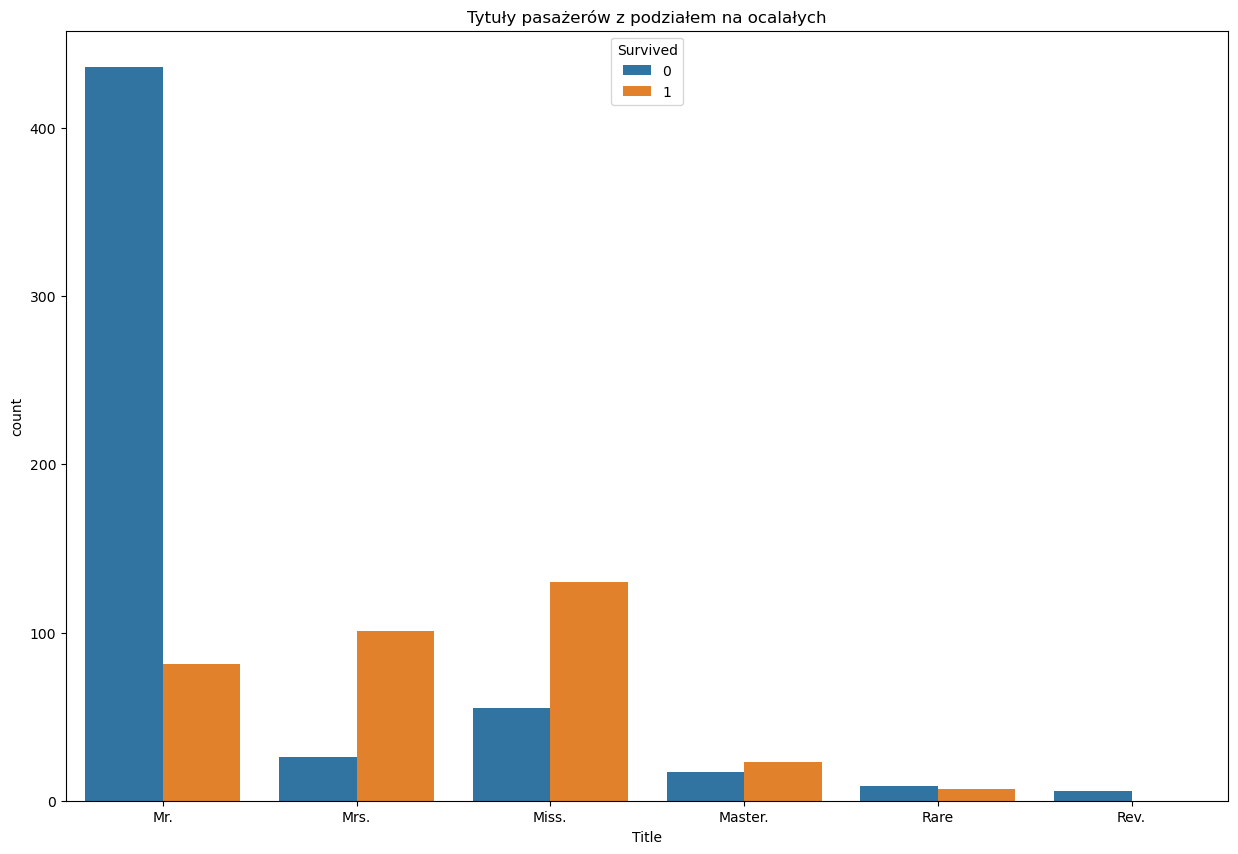

In [22]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Title', hue='Survived', data=process_data)
plt.title("Tytuły pasażerów z podziałem na ocalałych")
plt.show()

### Deck

Z pola cabin jesteśmy w stanie wydobyć informację, na jakim pokładzie pasażer miał kabinę. Większość wartości jest równa null w tej kolumnie. Zastąpmy wartość null nową wartością - __N__. Pozostałe wartości pokładów albo zapiszmy zgodnie z ich wartością, albo nadpiszmy wszystkie wartością __P__. 

In [23]:
class DeckCapture(BaseEstimator, TransformerMixin):
    def __init__(self, diff_deck = True):
        self.diff_deck = diff_deck
    def get_deck(self, cabin):
        return "N" if ps.isna(cabin) else (cabin[0] if self.diff_deck else 'P')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Deck'] = X['Cabin'].map(self.get_deck)
        return X
deck_capture = DeckCapture()   
deck_capture.transform(process_data)
del_columns = DelColumns(['Cabin'])
process_data = del_columns.transform(process_data)
process_data['Deck'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Pasażerowie bez wpisanej kabiny mają o wiele niższą przeżywalność niż ci ze wpisaną. Szczególnie jest to widoczna, gdy podzelujmy dane na klasy. Sam podział na kabiny jest trudny wyborem - czy go zostawić czy nadpisać wszystkie jedną wartością. Ustawimy ten parametr, jako zmienną w GridSearch

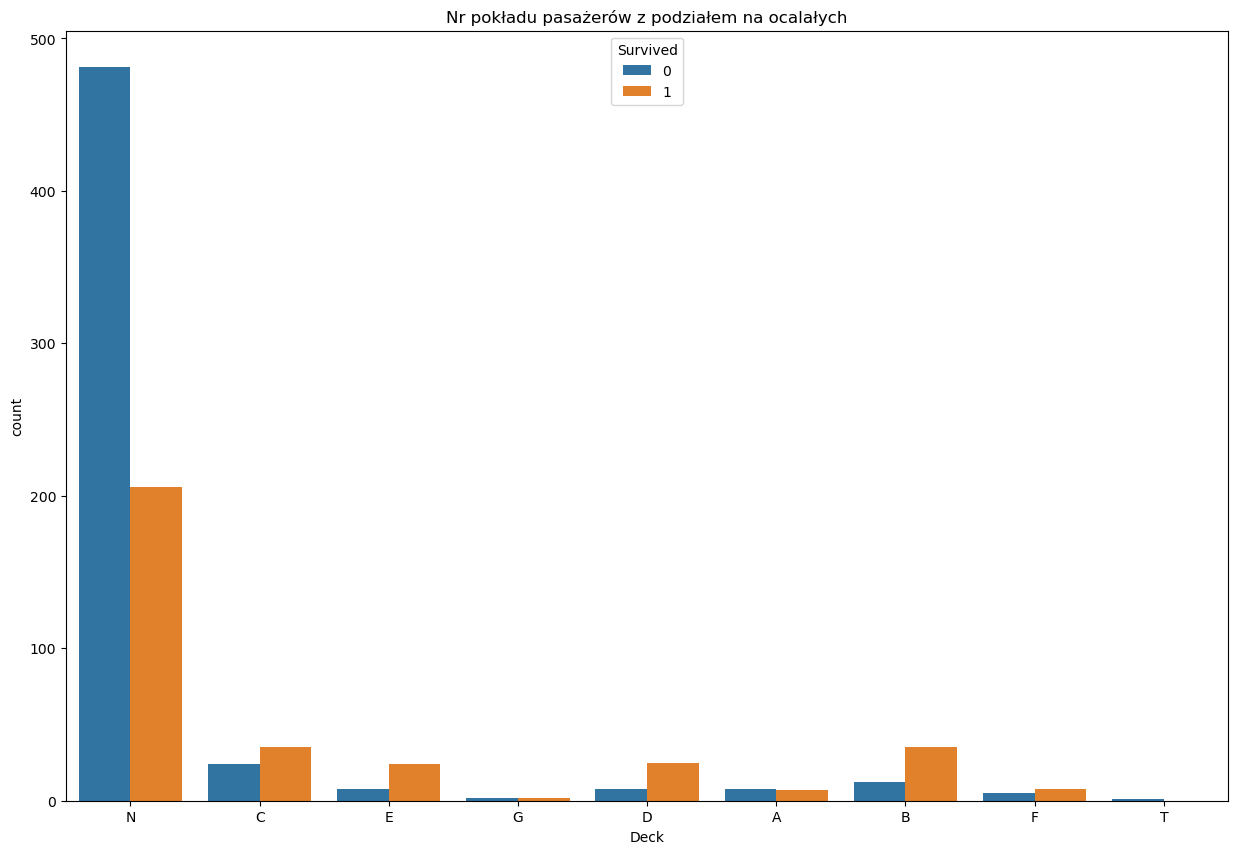

In [24]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Deck', hue='Survived', data=process_data)
plt.title("Nr pokładu pasażerów z podziałem na ocalałych")
plt.show()

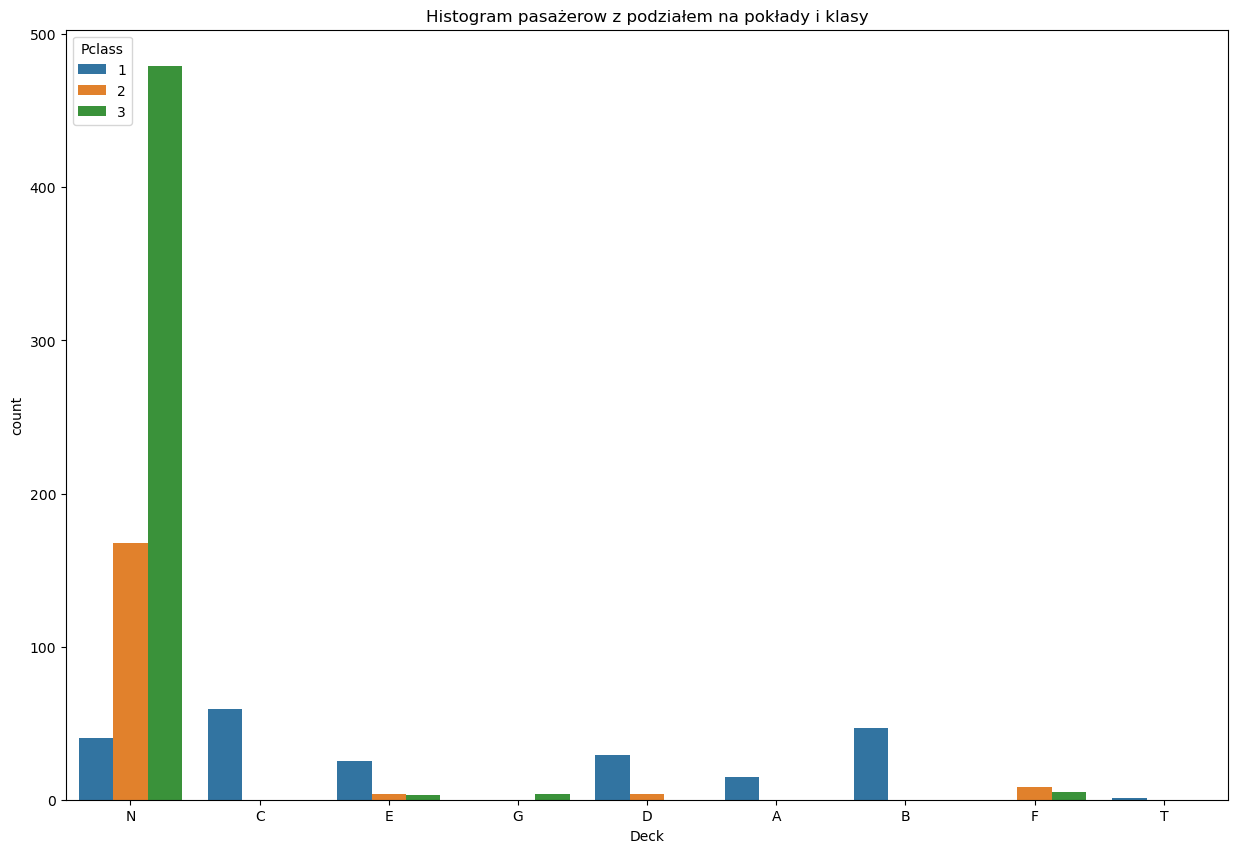

In [25]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Deck', hue='Pclass', data=process_data)
plt.title("Histogram pasażerow z podziałem na pokłady i klasy")
plt.show()

#### Interpretacja

Informacja o przypisanej kabinie do pasażera była głównie uzyskiwana z relacji ocalałych z katastrofy. Ofiary katastrofy z oczywistych przyczyn nie mogły udzielić informacje o swoim numerze kabiny. Dlatego istnieje tak duża korelacja między przeżywalnością a informacją o kabinie.

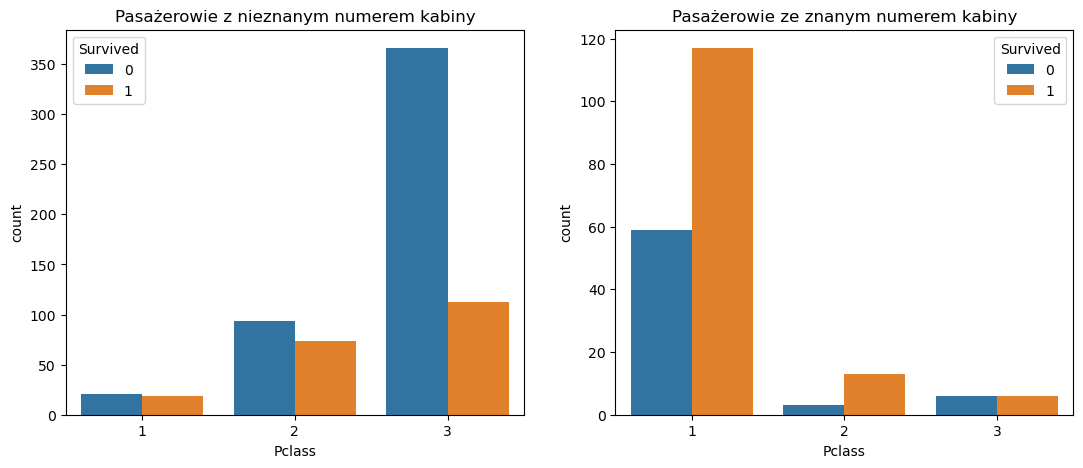

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.countplot(ax = ax[0], x='Pclass', hue='Survived', data=process_data[process_data['Deck'] == 'N'])
sns.countplot(ax = ax[1], x='Pclass', hue='Survived', data=process_data[process_data['Deck'] != 'N'])
ax[0].title.set_text("Pasażerowie z nieznanym numerem kabiny")
ax[1].title.set_text("Pasażerowie ze znanym numerem kabiny")
plt.show() 

In [27]:
process_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,0,3,male,22.0,1,0,7.2500,S,Mr.,N
1,1,1,female,38.0,1,0,71.2833,C,Mrs.,C
2,1,3,female,26.0,0,0,7.9250,S,Miss.,N
3,1,1,female,35.0,1,0,53.1000,S,Mrs.,C
4,0,3,male,35.0,0,0,8.0500,S,Mr.,N
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Rev.,N
887,1,1,female,19.0,0,0,30.0000,S,Miss.,B
888,0,3,female,NaN,1,2,23.4500,S,Miss.,N
889,1,1,male,26.0,0,0,30.0000,C,Mr.,C


### Family score

SibSp i Parch mają bardzo podobny rozkład Survived. Dodatkowo - generalizując - przechowują wartość o tym samym.
Aby ułatwić uogólnienie informacji, dodajmy nową kolumnę _Family_, która będzie sumą SibSp i Parch. W GridSearch zadecydujemy czy usuwamy SibsSp i Parch po wyliczeniu wartości _Family_

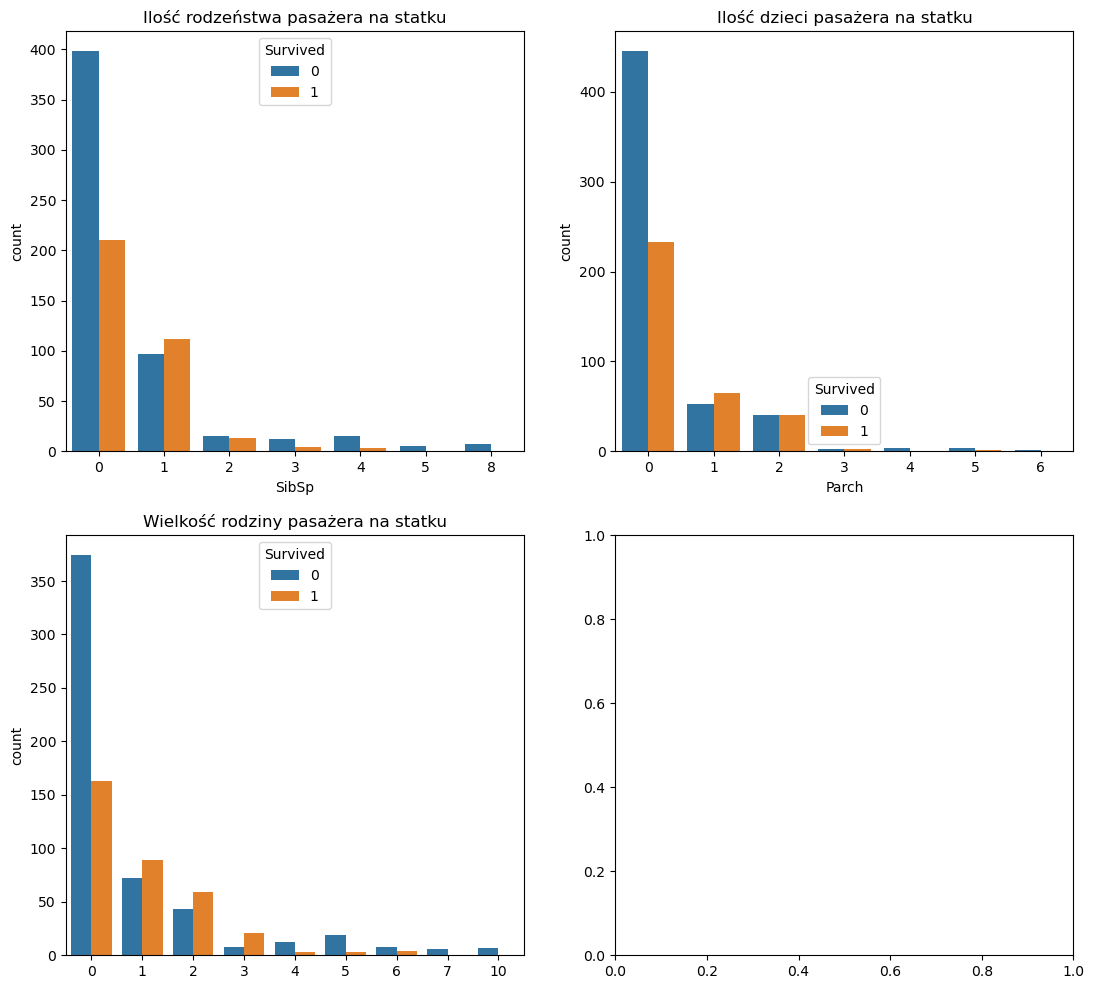

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(13, 12))
sns.countplot(ax = ax[0][0], x='SibSp', hue='Survived', data=process_data)
sns.countplot(ax = ax[0][1], x='Parch', hue='Survived', data=process_data)
sns.countplot(ax = ax[1][0], x=process_data["SibSp"] + process_data["Parch"], hue='Survived', data=process_data)
ax[0][0].title.set_text("Ilość rodzeństwa pasażera na statku")
ax[0][1].title.set_text("Ilość dzieci pasażera na statku")
ax[1][0].title.set_text("Wielkość rodziny pasażera na statku")
plt.show()

In [29]:
class FamilyScoreCapture(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Family'] = X['SibSp'] + X['Parch']
        return X
family_score = FamilyScoreCapture()
family_score.transform(process_data)
del_columns = DelColumns(['SibSp', 'Parch'])
process_data = del_columns.transform(process_data)
process_data

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Deck,Family
0,0,3,male,22.0,7.2500,S,Mr.,N,1
1,1,1,female,38.0,71.2833,C,Mrs.,C,1
2,1,3,female,26.0,7.9250,S,Miss.,N,0
3,1,1,female,35.0,53.1000,S,Mrs.,C,1
4,0,3,male,35.0,8.0500,S,Mr.,N,0
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,Rev.,N,0
887,1,1,female,19.0,30.0000,S,Miss.,B,0
888,0,3,female,NaN,23.4500,S,Miss.,N,3
889,1,1,male,26.0,30.0000,C,Mr.,C,0


### Missing values

W trzech kolumnach będziemy obsługiwać missing values
- __Age__ - będziemy wartość nadpisywać średnią wieku dla danego tytułu
- __Fare__ - będziemy wartość nadpisywać średnią ceny biletu dla danej klasy
- __Embarked__ - będziemy wartość nadpisywać wartość 'S' (występuje ona w 70% w zbiorze testowym)

In [30]:
class AgeNaNFill(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_age = ps.pivot_table(X, values="Age", index='Title', aggfunc= "mean").squeeze()
        return self
    def transform(self, X):
        mapped_values = self.mean_age[X[X['Age'].isna()]["Title"]]
        X.loc[X['Age'].isna(), "Age"] = mapped_values.values
        return X
class FareNaNFill(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_age = ps.pivot_table(X, values="Fare", index='Pclass', aggfunc= "mean").squeeze()
        return self
    def transform(self, X):
        mapped_values = self.mean_age[X[X['Fare'].isna()]["Pclass"]]
        X.loc[X['Fare'].isna(), "Fare"] = mapped_values.values
        return X
class EmbarkedNaNFill(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(value = {'Embarked': 'S'})
age_pipe = AgeNaNFill()
fare_pipe = FareNaNFill()
embarked_pipe = EmbarkedNaNFill()

age_pipe.fit(process_data)
fare_pipe.fit(process_data)
embarked_pipe.fit(process_data)

age_pipe.transform(process_data)
fare_pipe.transform(process_data)
embarked_pipe.transform(process_data)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Deck,Family
0,0,3,male,22.000000,7.2500,S,Mr.,N,1
1,1,1,female,38.000000,71.2833,C,Mrs.,C,1
2,1,3,female,26.000000,7.9250,S,Miss.,N,0
3,1,1,female,35.000000,53.1000,S,Mrs.,C,1
4,0,3,male,35.000000,8.0500,S,Mr.,N,0
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,13.0000,S,Rev.,N,0
887,1,1,female,19.000000,30.0000,S,Miss.,B,0
888,0,3,female,21.845638,23.4500,S,Miss.,N,3
889,1,1,male,26.000000,30.0000,C,Mr.,C,0


### Konwersja danych

#### Generalizacja

Spróbujemy podzielić wartości _Fare_ i _Age_ na kategorie. W GridSearch ustawimy jako parametr, czy włączamy konwersje, czy też nie. Podział na kategorie został wykonany metodą _widzi_mi_się_ lub został mocno zainspirowany, kogoś rozwiązaniem z internetu ¯\_(ツ)_/¯

#### Konwersja na dane liczbowe

Przekonwertujemy kolumnę _Sex_ na 0 i 1 w zależności od płci

In [31]:
class FareConvert(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.loc[ X['Fare'] <= 7.91, 'Fare'] = 0
        X.loc[(X['Fare'] > 7.91) & (X['Fare'] <= 50), 'Fare'] = 1
        X.loc[(X['Fare'] > 50) & (X['Fare'] <= 100), 'Fare'] = 2
        X.loc[(X['Fare'] > 100) & (X['Fare'] <= 300), 'Fare'] = 3
        X.loc[X['Fare'] > 300, 'Fare'] = 4
        return X
class AgeConvert(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.loc[ X['Age'] <= 7, 'Age'] = 0
        X.loc[(X['Age'] > 7) & (X['Age'] <= 17), 'Age'] = 1
        X.loc[(X['Age'] > 17) & (X['Age'] <= 30), 'Age'] = 2
        X.loc[(X['Age'] > 30) & (X['Age'] <= 60), 'Age'] = 3
        X.loc[(X['Age'] > 60) & (X['Age'] <= 77), 'Age'] = 4
        X.loc[X['Age'] > 77, 'Age'] = 5
        return X
class SexConvert(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.loc[ X['Sex'] == 'male', 'Sex'] = 0
        X.loc[ X['Sex'] == 'female', 'Sex'] = 1
        return X
sex_conv = SexConvert()
sex_conv.transform(process_data)
fare_conv = FareConvert()
fare_conv.transform(process_data)
age_conv = AgeConvert()
age_conv.transform(process_data)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Deck,Family
0,0,3,0,2.0,0.0,S,Mr.,N,1
1,1,1,1,3.0,2.0,C,Mrs.,C,1
2,1,3,1,2.0,1.0,S,Miss.,N,0
3,1,1,1,3.0,2.0,S,Mrs.,C,1
4,0,3,0,3.0,1.0,S,Mr.,N,0
...,...,...,...,...,...,...,...,...,...
886,0,2,0,2.0,1.0,S,Rev.,N,0
887,1,1,1,2.0,1.0,S,Miss.,B,0
888,0,3,1,2.0,1.0,S,Miss.,N,3
889,1,1,0,2.0,1.0,C,Mr.,C,0


### Podsumowanie preprocesingu

Tak przygotowane dane podamy naszym modelom. Na końcu jeszcze dodamy OneHotEncorder i StandardScaler

In [32]:
process_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  889 non-null    object 
 6   Title     891 non-null    object 
 7   Deck      891 non-null    object 
 8   Family    891 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


# Trenowanie modeli

Wczytujemy dane i usuwamy z nich kapitana, jako wartość odstającą.

In [33]:
train_data = load_titanic_data("train.csv")
print(train_data.loc[train_data['PassengerId'] == 746])
train_data.drop(train_data[train_data['PassengerId'] == 746].index, inplace=True)

     PassengerId  Survived  Pclass                          Name   Sex   Age  \
745          746         0       1  Crosby, Capt. Edward Gifford  male  70.0   

     SibSp  Parch     Ticket  Fare Cabin Embarked  
745      1      1  WE/P 5735  71.0   B22        S  


Dzielimy dane na input i output

In [34]:
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']

Robimy preprocessing danych, który nie musi być robiony w Pipelinie
- Z kolumny _Name_ tworzymy kolumnę _Title_- __TitleCapture()__, __TitleConverter()__
- Tworzymy kolumne _Family_ z _Parch_ i _SibSp_ - __EmbarkedNaNFill()__
- Nadpisujemy nulle w _Embarked_ wartością 'S' -__EmbarkedNaNFill()__
- Konwertujemy kolumne _Sex_ na wartości numeryczne - __SexConvert()__
- Usuwamy kolumny _Ticket_, _PassengerId_, _Name_ - __DelColumns()__

In [35]:
def prepare_data(X):
    transforms = [TitleCapture(), TitleConverter(), FamilyScoreCapture(), EmbarkedNaNFill(), SexConvert(), DelColumns(['Ticket', 'PassengerId', 'Name'])]
    for t in transforms:
        X = t.transform(X)
    return X

In [36]:
X = prepare_data(X)
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family
0,3,0,22.0,1,0,7.2500,NaN,S,Mr.,1
1,1,1,38.0,1,0,71.2833,C85,C,Mrs.,1
2,3,1,26.0,0,0,7.9250,NaN,S,Miss.,0
3,1,1,35.0,1,0,53.1000,C123,S,Mrs.,1
4,3,0,35.0,0,0,8.0500,NaN,S,Mr.,0
...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,NaN,S,Rev.,0
887,1,1,19.0,0,0,30.0000,B42,S,Miss.,0
888,3,1,NaN,1,2,23.4500,NaN,S,Miss.,3
889,1,0,26.0,0,0,30.0000,C148,C,Mr.,0


### Pipeline

Nasz pipeline będzie się składać z następujących etapów
- Uzyskanie informacji o pokładzie z kolumny _Cabin_ - __DeckCapture()__
- Usunięcie kolumny _Cabin_ - __DelColumns()__
- Nadpisanie missing values w _Age_ i _Fare - __AgeNaNFill()__, __FareNaNFill()__
- Konwersja kolumny _Age_ i _Fare_ na kategorie - __AgeConvert()__, __FareConvert()__, 
- Usunięcie kolumny _SibSp_ i _Parch_ - __DelColumns()__
- Utworzenie kolumn binarnych z kolumn kategorycznych _Embarked_, _Deck_, _Title_ - __OneHotEncorder()__
- Normalizacja danych - __StandardScaler()__
- Na końcu ustawiamy nasz model

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

pipeSvc = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', SVC(probability = True))
])

### SVC rbf

In [38]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__C': [0.1, 1, 10, 100],
              'classifier__gamma': [0.001, 0.01, 0.1, 1]}

svc_rbf = GridSearchCV(pipeSvc, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 2, refit=True, n_jobs = -1)

In [39]:
svc_rbf.fit(X, y)
svc_rbf.best_params_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


{'age_conv': AgeConvert(),
 'classifier__C': 10,
 'classifier__gamma': 0.01,
 'deck_converter__diff_deck': False,
 'del_family_columns__columns': [],
 'fare_conv': None}

In [40]:
svc_rbf.best_score_

0.8404494382022472

### SVC linear

In [41]:
pipe_svc_lin = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', SVC(kernel="linear", max_iter=50000, probability = True))
])

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__C': [0.001, 0.01 , 0.1, 1, 10, 100],
              'classifier__gamma': [10 ** -10, 10 ** -5, 10 ** 2]}

svc_lin = GridSearchCV(pipe_svc_lin, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 3, refit=True, n_jobs = -1)

In [42]:
svc_lin.fit(X, y)
svc_lin.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'age_conv': None,
 'classifier__C': 1,
 'classifier__gamma': 1e-10,
 'deck_converter__diff_deck': False,
 'del_family_columns__columns': ['SibSp', 'Parch'],
 'fare_conv': None}

In [43]:
svc_lin.best_score_

0.8292134831460676

### Linear Regression

In [44]:
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', LogisticRegression())
])

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__C': [0.00001, 0.001, 0.1, 1, 10, 100],}

lr = GridSearchCV(pipe_lr, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 3, refit=True, n_jobs = -1)

In [45]:
lr.fit(X, y)
lr.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'age_conv': AgeConvert(),
 'classifier__C': 1,
 'deck_converter__diff_deck': False,
 'del_family_columns__columns': [],
 'fare_conv': FareConvert()}

In [46]:
lr.best_score_

0.8348314606741575

### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__splitter': ['best', 'random'],
              'classifier__criterion' : ['gini', 'entropy'],
              'classifier__min_samples_leaf': [8, 9, 10, 11, 12, 13, 14],
              'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8,9,10,11]}

dt = GridSearchCV(pipe_dt, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 3, refit=True, n_jobs = -1)

In [48]:
dt.fit(X, y)
dt.best_params_

Fitting 5 folds for each of 4480 candidates, totalling 22400 fits


{'age_conv': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 11,
 'classifier__splitter': 'best',
 'deck_converter__diff_deck': True,
 'del_family_columns__columns': [],
 'fare_conv': None}

In [49]:
dt.best_score_

0.8370786516853933

### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier(min_samples_leaf = 2))
])

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__n_estimators': [100, 200, 500, 1000],
              'classifier__criterion' : ['gini', 'entropy'],}

rf = GridSearchCV(pipe_rf, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 3, refit=True, n_jobs = -1)

In [51]:
rf.fit(X, y)
rf.best_params_

Fitting 5 folds for each of 128 candidates, totalling 640 fits


{'age_conv': None,
 'classifier__criterion': 'entropy',
 'classifier__n_estimators': 1000,
 'deck_converter__diff_deck': False,
 'del_family_columns__columns': ['SibSp', 'Parch'],
 'fare_conv': None}

In [52]:
rf.best_score_

0.8415730337078653

### Ada Boost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

pipe_ada = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', AdaBoostClassifier(random_state = 123))
])

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__n_estimators': [50, 100, 150, 200, 500],
              'classifier__learning_rate' : [0.001, 0.1, 1, 10]}

ada = GridSearchCV(pipe_ada, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 3, refit=True, n_jobs = -1)

In [54]:
ada.fit(X, y)
ada.best_params_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


{'age_conv': AgeConvert(),
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 200,
 'deck_converter__diff_deck': False,
 'del_family_columns__columns': ['SibSp', 'Parch'],
 'fare_conv': FareConvert()}

In [55]:
ada.best_score_

0.8325842696629213

### KNeighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ("deck_converter", DeckCapture()),
    ("del_str_val", DelColumns(['Cabin'])),
    ("age_nan", AgeNaNFill()),
    ("fare_nan", FareNaNFill()),
    ("fare_conv", FareConvert()),
    ("age_conv", AgeConvert()),
    ("del_family_columns", DelColumns(['SibSp', 'Parch'])),
    ("dummies", ColumnTransformer([('onehot', OneHotEncoder(handle_unknown="ignore"), ['Embarked', 'Deck', 'Title'])], remainder='passthrough')),
    ("scaler", StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

param_grid = {'deck_converter__diff_deck': [True, False],
              'del_family_columns__columns': [[], ['SibSp', 'Parch']],
              'fare_conv': [None, FareConvert()],
              'age_conv': [None, AgeConvert()],
              'classifier__n_neighbors': [2, 3, 5, 10, 30, 50, 100],
              'classifier__weights' : ['uniform', 'distance'],
              'classifier__metric' : ['euclidean', 'manhattan', 'cosine']}

knn = GridSearchCV(pipe_knn, param_grid = param_grid, cv=kfold, return_train_score=True, verbose = 3, refit=True, n_jobs = -1)

In [57]:
knn.fit(X, y)
knn.best_params_

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


{'age_conv': None,
 'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 10,
 'classifier__weights': 'uniform',
 'deck_converter__diff_deck': False,
 'del_family_columns__columns': [],
 'fare_conv': None}

In [58]:
knn.best_score_

0.8337078651685393

# Porównanie modeli

Wszystkie modele dały zbliżone wyniki wahające się między sobą w granicy procenta. Uwaga przykuwa Random Forest, który mocno overfituje do danych. Na kaaglu najlepsze wyniki dał __SVC rbf__ i __Random Forest__, ale wyniki między modelami różnią się minimalnie na poziomie kilku więcej przypisanych dobrze labeli (1% to około 5 labeli).

In [59]:
compare_models = ps.DataFrame(
    {'Model': ['SVC rbf', 'SVC linear', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Ada Boosting', 'KNeighbors'],
     'Validation Score': [svc_rbf.best_score_, svc_lin.best_score_, lr.best_score_, dt.best_score_, rf.best_score_, ada.best_score_, knn.best_score_],
     'Train Score': [svc_rbf.score(X,y), svc_lin.score(X,y), lr.score(X,y), dt.score(X,y), rf.score(X,y), ada.score(X,y), knn.score(X,y)],
     'Kaagle Score': [0.78229, 0.77511, 0.76794, 0.76555, 0.78229, 0.77272, 0.77033]
    })
compare_models

D:\Programs\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,Model,Validation Score,Train Score,Kaagle Score
0,SVC rbf,0.840449,0.842697,0.78229
1,SVC linear,0.829213,0.831461,0.77511
2,Linear Regression,0.834831,0.834831,0.76794
3,Decision Tree,0.837079,0.841573,0.76555
4,Random Forest,0.841573,0.910112,0.78229
5,Ada Boosting,0.832584,0.842697,0.77272
6,KNeighbors,0.833708,0.856180,0.77033


### Voting Classifier

Sprawdźmy jeszcze, czy Voting Classifier będzie w stanie poprawić wynik naszych modeli

In [60]:
from sklearn.ensemble import VotingClassifier

voting_soft = VotingClassifier(
    estimators=[('svc_rbf', svc_rbf), ('svc_lin', svc_lin), ('lr', lr), ('dt', dt), ('rf', rf), ('ada', ada), ('knn', knn)],
    voting='soft', n_jobs = -1)

voting_hard = VotingClassifier(
    estimators=[('svc_rbf', svc_rbf), ('svc_lin', svc_lin), ('lr', lr), ('dt', dt), ('rf', rf), ('ada', ada), ('knn', knn)],
    voting='hard', n_jobs = -1)

In [61]:
voting_soft.fit(X, y)

VotingClassifier(estimators=[('svc_rbf',
                              GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                                           estimator=Pipeline(steps=[('deck_converter',
                                                                      DeckCapture()),
                                                                     ('del_str_val',
                                                                      DelColumns(columns=['Cabin'])),
                                                                     ('age_nan',
                                                                      AgeNaNFill()),
                                                                     ('fare_nan',
                                                                      FareNaNFill()),
                                                                     ('fare_conv',
                                                                      Fare

In [62]:
voting_hard.fit(X, y)

VotingClassifier(estimators=[('svc_rbf',
                              GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                                           estimator=Pipeline(steps=[('deck_converter',
                                                                      DeckCapture()),
                                                                     ('del_str_val',
                                                                      DelColumns(columns=['Cabin'])),
                                                                     ('age_nan',
                                                                      AgeNaNFill()),
                                                                     ('fare_nan',
                                                                      FareNaNFill()),
                                                                     ('fare_conv',
                                                                      Fare

In [63]:
voting_soft.score(X, y)

0.849438202247191

In [64]:
voting_hard.score(X, y)

D:\Programs\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.8471910112359551

Oba modele dają zbliżone wyniki w porównaniu do reszty modeli. Na kaaglu oba modele dają wynik __77.99%__, czyli dobry, ale nie najlepszy.

# Zapisanie wyników

In [65]:
import joblib
def safe_model(model, name):
    test_data = load_titanic_data("test.csv")
    X = prepare_data(test_data)
    y_pred = model.predict(X)
    submission = ps.DataFrame({"PassengerId": test_data["PassengerId"], "Survived": y_pred})
    submission.to_csv('out/{}.csv'.format(name), index=False)
    joblib.dump(model, 'model/{}.sav'.format(name))
    return

In [66]:
safe_model(svc_rbf, 'svc_rbf')
safe_model(svc_lin, 'svc_lin')
safe_model(lr, 'linear_regresion')
safe_model(dt, 'decision_tree')
safe_model(rf, 'random_forest')
safe_model(ada, 'ada_boosting')
safe_model(knn, 'kernel_neighbours')

D:\Programs\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [67]:
safe_model(voting_soft, 'voting_soft')
safe_model(voting_hard, 'voting_hard')

D:\Programs\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Podsumowanie

Żaden model nie okazał się wyraźnie lepszy od pozostałych. Róźnice między nimi wahają się w granicy procenta. Najlepszy wynik uzyskały __SVC rbf__ i __Random Forest__, ale są tu róźnice minimalne.

Nasz końcowy wynik to __78.22%__ na kaaglu